# Verify PTRs off by 2x
> When I ran `large_simulation_experiment`, there was a weird trend. Here, I explore it:

In [41]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
results = pd.read_csv("../data/scores/large_simulation_experiment.csv", index_col=0, dtype={"genome": str})

In [6]:
results.head()

,genome,trial,a,b,a_hat,b_hat,final_loss,a_err,b_err,n_reads
0,398579.7,0,7612996,1.371131,0.654218,0.574916,3.079980e-08,7.612994e+06,0.405851,10564
1,398579.7,1,5732545,1.824073,0.455166,1.000000,3.932661e-05,7.612994e+06,1.347151,8684
2,398579.7,2,6901421,1.542986,0.685145,0.652671,4.592270e-06,7.612994e+06,0.549532,10047
3,398579.7,3,6545181,1.216062,0.770732,0.000000,1.227663e-06,7.612994e+06,0.371131,8715
4,398579.7,4,2440055,1.829877,0.718800,0.797054,3.083639e-05,7.612994e+06,0.847863,3719


## Verify 2x trend in errors

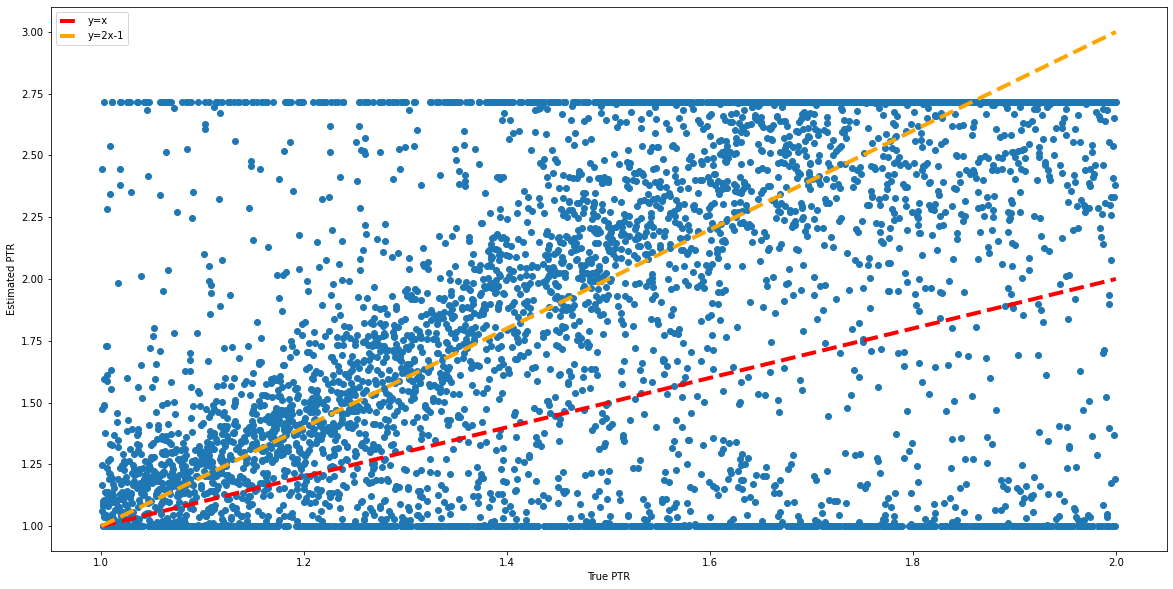

In [39]:
fig = plt.figure(figsize=(20, 10))
plt.plot(results["b"], np.exp(results["b_hat"]), "o")
plt.plot([1,2], [1,2], "--", color="red", label="y=x", lw=4)
plt.plot([1,2], [1,3], "--", color="orange", label="y=2x-1", lw=4)
plt.xlabel("True PTR")
plt.ylabel("Estimated PTR")
plt.legend()

[]

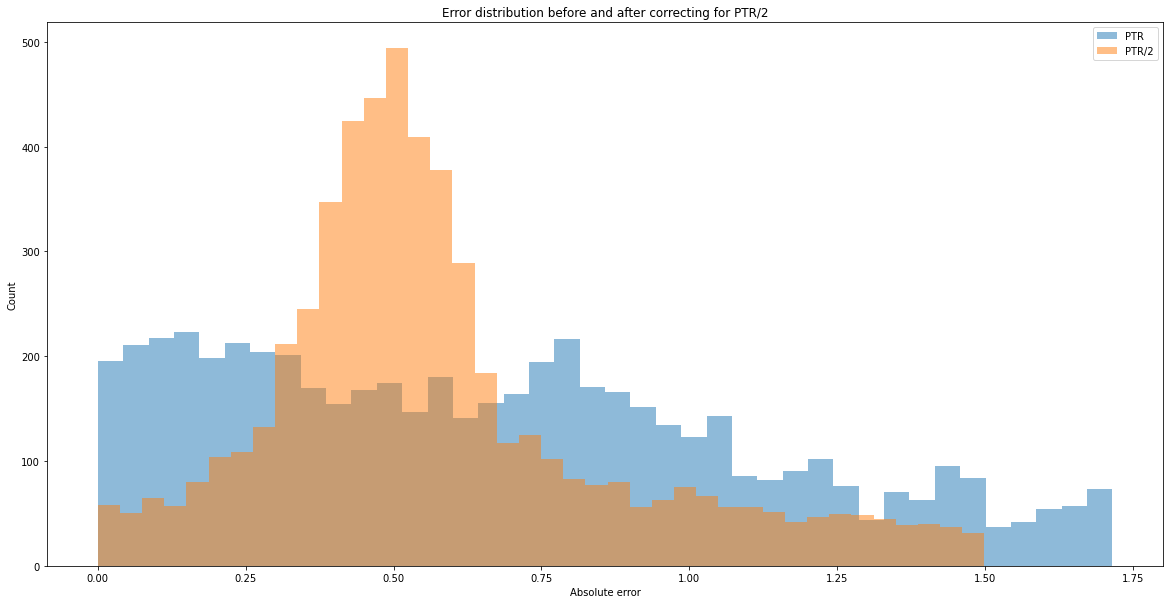

In [30]:
fig = plt.figure(figsize=(20, 10))
plt.hist(results["b_err"], bins=40, alpha=0.5, label="PTR")
new_errs = np.abs(np.exp(results["b_hat"]) / 2 - results["b"])
plt.hist(new_errs, bins=40, alpha=0.5, label="PTR/2")
plt.xlabel("Absolute error")
plt.ylabel("Count")
plt.title("Error distribution before and after correcting for PTR/2")
plt.legend()
plt.plot()

[]

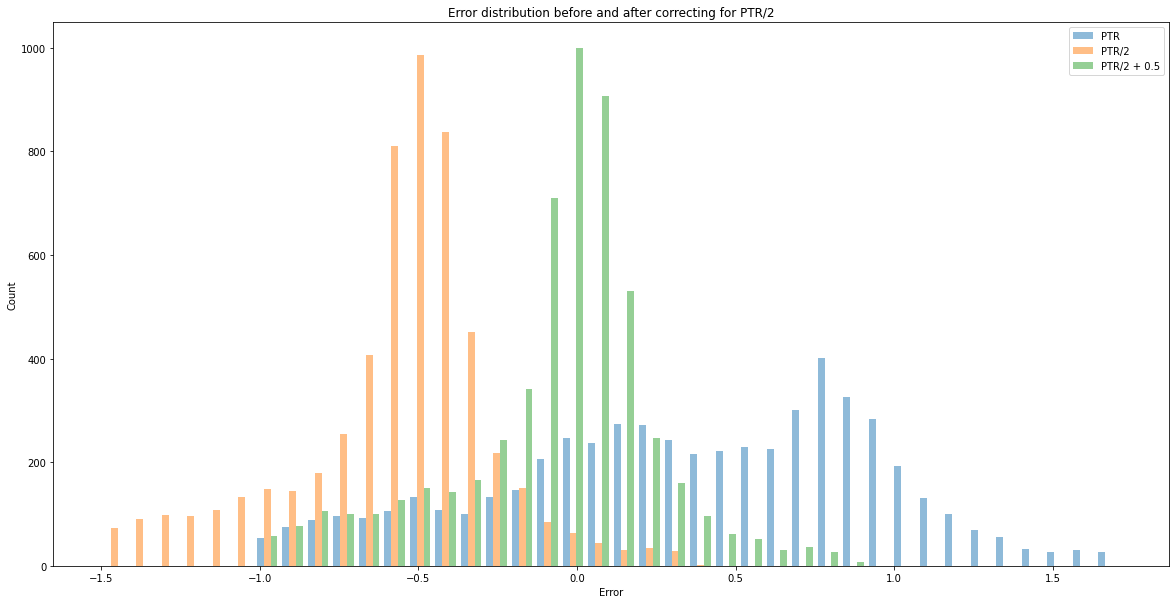

In [38]:
fig = plt.figure(figsize=(20, 10))
old_errs_rel = np.exp(results["b_hat"]) - results["b"] # no abs
new_errs_rel = np.exp(results["b_hat"]) / 2 - results["b"]
affine_errs_rel = np.exp(results["b_hat"]) / 2 - results["b"] + 0.5
plt.hist(
    [old_errs_rel, new_errs_rel, affine_errs_rel], 
    bins=40, 
    alpha=0.5, 
    label=["PTR", "PTR/2", "PTR/2 + 0.5"]
)
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Error distribution before and after correcting for PTR/2")
plt.legend()
plt.plot()

## Checking simulation code for this problem
OK, so something is definitelly up with that 2x factor...


In [42]:
from src.simulation import ptr_curve

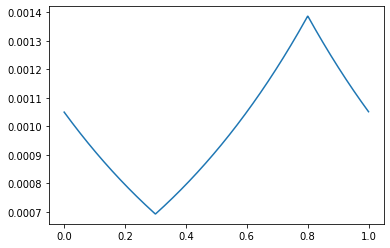

In [96]:
# Wait, the PTR curve is wrong! The OOR is in the wrong place...
plt.plot(*ptr_curve(1000, 2, 200))

PTR 1 is ~1.99
[0.2        0.17979798 0.15959596 0.13939394 0.11919192 0.0989899
 0.07878788 0.05858586 0.03838384 0.01818182 0.0020202  0.02222222
 0.04242424 0.06262626 0.08282828 0.1030303  0.12323232 0.14343434
 0.16363636 0.18383838 0.2040404  0.22424242 0.24444444 0.26464646
 0.28484848 0.30505051 0.32525253 0.34545455 0.36565657 0.38585859
 0.40606061 0.42626263 0.44646465 0.46666667 0.48686869 0.50707071
 0.52727273 0.54747475 0.56767677 0.58787879 0.60808081 0.62828283
 0.64848485 0.66868687 0.68888889 0.70909091 0.72929293 0.74949495
 0.76969697 0.78989899 0.81010101 0.83030303 0.85050505 0.87070707
 0.89090909 0.91111111 0.93131313 0.95151515 0.97171717 0.99191919
 0.98787879 0.96767677 0.94747475 0.92727273 0.90707071 0.88686869
 0.86666667 0.84646465 0.82626263 0.80606061 0.78585859 0.76565657
 0.74545455 0.72525253 0.70505051 0.68484848 0.66464646 0.64444444
 0.62424242 0.6040404  0.58383838 0.56363636 0.54343434 0.52323232
 0.5030303  0.48282828 0.46262626 0.44242424 0.4

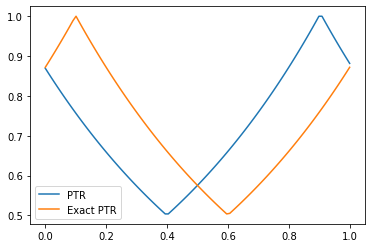

In [95]:
# This shows that the PTR curve funtion has always been wrong for nonzero OOR

x, y = ptr_curve(100, 2, oor=10)
print(f"PTR 1 is ~{y.max() / y.min():.2f}")

def exact_coverage_curve(log_ptr, rna_locations, size, oor):
    # rna_locations = db[genome]["16s_position"] / db[genome]["size"]
    # oor = db[genome]["oor_position"].max() / db[genome]["size"] # max is fine
    rna_locations /= size
    oor /= size
    dists1 = np.abs(rna_locations - oor)
    dists2 = np.abs(rna_locations - (oor + 1))
    dists = 2*np.minimum(dists1, dists2)
    print(dists)
    return rna_locations, np.exp(1 - log_ptr * dists)

x2, y2 = exact_coverage_curve(np.log(2), x, size=1, oor=0.1)
print(f"PTR 2 is ~{y2.max() / y2.min():.2f}")

plt.plot(x, y / y.max(), label="PTR")
print(f"PTR: {y.max() / y.min():.2f}")
plt.plot(x2, y2 / y2.max(), label="Exact PTR")
print(f"PTR: {y2.max() / y2.min():.2f}")
plt.legend()

True PTR: 1.5
PTR: 1.49
PTR: 1.49


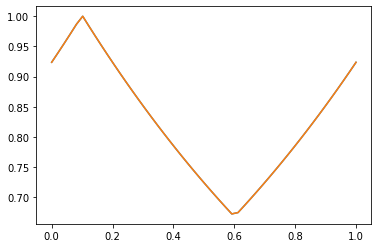

In [99]:
ptr = 1.5

x3 = np.linspace(0, 1)
d3 = np.minimum(np.abs(x3 - 0.1), np.abs(x3 - 1.1))
y3 = np.power(ptr, -2*d3 + 1)
y4 = np.exp(1 - np.log(ptr)*d3*2) # Aha! So the distances need to be 2xed

print(f"True PTR: {ptr}")
plt.plot(x3, y3 / y3.max(), label="PTR, analytic")
print(f"PTR: {y3.max() / y3.min():.2f}")
plt.plot(x3, y4 / y4.max(), label="PTR, analytic using exp")
print(f"PTR: {y4.max() / y4.min():.2f}")